# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, lit, countDistinct
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml import Pipeline

import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np

%matplotlib inline
scaler = StandardScaler()

AttributeError: Cannot load _jvm from SparkContext. Is SparkContext initialized?

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Capstone Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

Let's first import the data, look into what each variable stands for and which variables could be of interest for predicting a churn rate.

In [3]:
#load data
df = spark.read.json("mini_sparkify_event_data.json")

df.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [4]:
#shape of the dataset
df.count(), len(df.columns)

(286500, 18)

In [5]:
#how is structured the dataset
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



I don't think the following variables are very relevant for identifying users who cancel their service so I won't investigate them :  
- artist  
- firstName  
- lastName    
- method  
- registration  
- song  

On the other hand, some of the other variables are not very explicit so I would like to know what they are about - such as auth, level, status, and userAgent.

###### 1. auth variable

In [6]:
df.groupBy("auth").agg(countDistinct("userId")).sort("auth").show()

+----------+----------------------+
|      auth|count(DISTINCT userId)|
+----------+----------------------+
| Cancelled|                    52|
|     Guest|                     1|
| Logged In|                   225|
|Logged Out|                     1|
+----------+----------------------+



auth likely represents the status of the users. Among our 225 different users in our dataset, only 52 did cancel their service.  
It might be used to identify the users who left, but otherwise we won't need it in our model.

###### 2. level

In [7]:
df.groupby("level").agg(countDistinct("userId")).sort("level").show()

+-----+----------------------+
|level|count(DISTINCT userId)|
+-----+----------------------+
| free|                   196|
| paid|                   166|
+-----+----------------------+



Level represents whether the account if free or paid. It might be useful later.  
We can see that there are 362 entries - even though we only have 225 different users - which means some have changed their level at some point - whether upgrading or downgrading their service.  
We might want to extract the last known value for each user but also to identify those who updated their level.

###### 3. status

In [8]:
df.groupby("status").agg(countDistinct("userId")).sort("status").show()

+------+----------------------+
|status|count(DISTINCT userId)|
+------+----------------------+
|   200|                   226|
|   307|                   224|
|   404|                   118|
+------+----------------------+



We can't be sure of what it is because we don't have any legend, but once again some users have changed of status. We shall see in the explanatory analysis whether or not it is important for identifying users who cancel their service.

###### 4. userAgent

In [9]:
df.select("userAgent").dropDuplicates().sort("userAgent").show()

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [10]:
df.select("userAgent").dropDuplicates().count()

57

Lokks like it has to do with the web browser and the computer used. There are not many values but I don't think I can help identifying leaving customers so we won't go any further.

Before doing some exploratory analysis, we want to do 3 more tasks.  
First we want to look for missing values in our dataset.  
Next we will define what is a churning client.  
Finaly we will extract from the ts variable the following informations : the number of days since registration, the number of days as free user and the number of days as paid user.

###### 1. missing values

In [11]:
df.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [12]:
df.groupBy("gender").agg(countDistinct("userId")).sort("gender").show()

+------+----------------------+
|gender|count(DISTINCT userId)|
+------+----------------------+
|  null|                     1|
|     F|                   104|
|     M|                   121|
+------+----------------------+



There is 1 missing value in the gender column. We don't know whether it is really missing or if it is another gender than male or female but it shouldn't really modify our results. We will then keep it and consider it as a third level.

In [13]:
df.groupBy("length").agg(countDistinct("userId")).sort("length").show(5)

+-------+----------------------+
| length|count(DISTINCT userId)|
+-------+----------------------+
|   null|                   225|
|0.78322|                     1|
|2.16771|                     1|
|4.04853|                     2|
| 4.8322|                     1|
+-------+----------------------+
only showing top 5 rows



In [14]:
df.select("length").count()

286500

There are some missing values but it can be ignored because we will take an average of the length of the session and the missing values are to sparse to be of any significance.

In [15]:
df.groupBy("page").agg(count("userId")).sort("page").show()

+--------------------+-------------+
|                page|count(userId)|
+--------------------+-------------+
|               About|          924|
|          Add Friend|         4277|
|     Add to Playlist|         6526|
|              Cancel|           52|
|Cancellation Conf...|           52|
|           Downgrade|         2055|
|               Error|          258|
|                Help|         1726|
|                Home|        14457|
|               Login|         3241|
|              Logout|         3226|
|            NextSong|       228108|
|            Register|           18|
|         Roll Advert|         3933|
|       Save Settings|          310|
|            Settings|         1514|
|    Submit Downgrade|           63|
| Submit Registration|            5|
|      Submit Upgrade|          159|
|         Thumbs Down|         2546|
+--------------------+-------------+
only showing top 20 rows



In [16]:
df.groupBy("sessionId").agg(countDistinct("userId")).sort("sessionId").show(5)

+---------+----------------------+
|sessionId|count(DISTINCT userId)|
+---------+----------------------+
|        1|                     4|
|        2|                     1|
|        3|                     3|
|        4|                     1|
|        5|                     3|
+---------+----------------------+
only showing top 5 rows



In [17]:
df.groupBy("status").agg(countDistinct("userId")).sort("status").show()

+------+----------------------+
|status|count(DISTINCT userId)|
+------+----------------------+
|   200|                   226|
|   307|                   224|
|   404|                   118|
+------+----------------------+



In [18]:
df.groupBy("userId").count().sort("userId").show(5)

+------+-----+
|userId|count|
+------+-----+
|      | 8346|
|    10|  795|
|   100| 3214|
|100001|  187|
|100002|  218|
+------+-----+
only showing top 5 rows



There are 8346 rows with a missing userId. Given that we can't idenfity the customer without it, we will remove this row from our analysis.

In [19]:
#remove rows with a missing userId
df_clean = df.filter(df.userId != "")
df_clean.count()

278154

###### 2. define churn
A customer is said to have churned when he has cancelled his service. We will need the Cancellation Confirmation event for this.  
We could also look for the customers downgrading their service but we will instead use this information as a feature for prediction the customers cancelling their service.

In [20]:
#identify the lines where the user cancel their service
flag_cancellation_event = udf(lambda x:1 if x=="Cancellation Confirmation" else 0, IntegerType())

df_clean = df_clean.withColumn("top_churn", flag_cancellation_event("page"))

#create a list of the user who cancelled their service
churned_user = df_clean \
    .filter(df_clean.top_churn==1) \
    .select("userId") \
    .dropDuplicates()

churned_user_list = [row["userId"] for row in churned_user.collect()]

#top every row of the churning users
df_clean = df_clean \
    .withColumn("churned", when(df_clean.userId.isin(churned_user_list), 1).otherwise(0))

df_clean.groupBy("churned").agg(countDistinct("userId")).show()

+-------+----------------------+
|churned|count(DISTINCT userId)|
+-------+----------------------+
|      1|                    52|
|      0|                   173|
+-------+----------------------+



As exected, we have 52 users who did cancel their service.

###### 3. retreat ts variable

In [21]:
#number of days since registration
user_last_ts = df_clean.groupBy("userId").max("ts").sort("userId")
user_reg_ts = df_clean.select("userId", "registration").dropDuplicates().sort("userId")

ndays_since_reg = user_reg_ts.join(user_last_ts, user_reg_ts.userId==user_last_ts.userId) \
    .select(user_reg_ts.userId, ((user_last_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("nDays")) \
    .sort("userId")

df_clean = df_clean.join(ndays_since_reg, "userId", "left")

In [22]:
#number of days as paid user
first_day_paid_user = df_clean.filter(df_clean.level=="paid") \
    .groupBy("userId") \
    .min("ts")
last_day_paid_user = df_clean.filter(df_clean.level=="paid") \
    .groupBy("userId") \
    .max("ts")

ndays_paid_user = first_day_paid_user.join(last_day_paid_user, "userId") \
    .select(first_day_paid_user.userId, ((last_day_paid_user["max(ts)"]-first_day_paid_user["min(ts)"])/(1000*60*60*24)).alias("ndays_paid"))

df_clean = df_clean.join(ndays_paid_user, "userId", "left")

In [23]:
#number of days as free user
first_day_free_user = df_clean.filter(df_clean.level=="free") \
    .groupBy("userId") \
    .min("ts")
last_day_free_user = df_clean.filter(df_clean.level=="free") \
    .groupBy("userId") \
    .max("ts")

ndays_free_user = first_day_free_user.join(last_day_free_user, "userId") \
    .select(first_day_free_user.userId, ((last_day_free_user["max(ts)"]-first_day_free_user["min(ts)"])/(1000*60*60*24)).alias("ndays_free"))

df_clean = df_clean.join(ndays_free_user, "userId", "left")


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

###### 1. gender variable

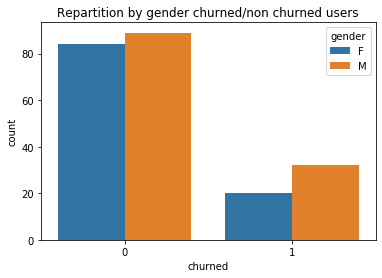

In [24]:
churn_gender = df_clean.groupBy("churned", "gender") \
    .agg(countDistinct("userId").alias("count")) \
    .toPandas()

sb.barplot(x="churned", y="count", hue="gender", data=churn_gender)
plt.title("Repartition by gender churned/non churned users");

###### 2. length variable
We will look here at the average length of songs between churned users and the others.  
We first compute the number of users per group - churned vs not churned -, then the total length of songs per group. The ratio of these two numbers will give us how much time each group has listened to music in average.

In [25]:
#number of songs played per user
nb_song_per_user = df_clean.filter(df_clean.page=="NextSong") \
    .groupBy("churned") \
    .agg(countDistinct("userId").alias("n_songs"))
nb_song_per_user.show()

+-------+-------+
|churned|n_songs|
+-------+-------+
|      1|     52|
|      0|    173|
+-------+-------+



In [26]:
#total length of songs
length_song_per_user = df_clean.filter(df_clean.page=="NextSong") \
    .groupBy("churned") \
    .sum("length")
length_song_per_user.show()

+-------+-------------------+
|churned|        sum(length)|
+-------+-------------------+
|      1|  9048741.964669999|
|      0|4.777688018192997E7|
+-------+-------------------+



The ratio between the two groups of length is approximately 5.3 and the ratio of number of songs is 3.3 - which leads me to think the total length can be used in our model.

###### 3. level variable

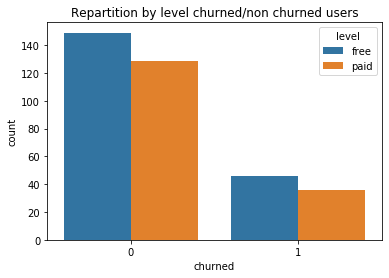

In [27]:
churn_level = df_clean.groupBy("churned", "level") \
    .agg(countDistinct("userId").alias("count")) \
    .toPandas()

sb.barplot(x="churned", y="count", hue="level", data=churn_level)
plt.title("Repartition by level churned/non churned users");

###### 4. status variable

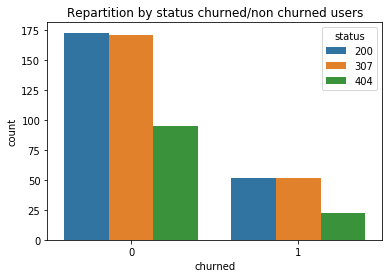

In [28]:
churn_status = df_clean.groupBy("churned", "status") \
    .agg(countDistinct("userId").alias("count")) \
    .toPandas()

sb.barplot(x="churned", y="count", hue="status", data=churn_status)
plt.title("Repartition by status churned/non churned users");

###### 5. page variable

In [29]:
#pivot table to plot each page value separately
churn_page = df_clean.groupBy("userId").pivot("page").count().fillna(0).toPandas()
churn_page.rename(columns={"Cancellation Confirmation": "Churn"}, inplace=True)

In [30]:
churn_page.head()

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,100010,1,4,7,0,0,0,0,2,11,5,275,52,0,0,0,0,5,17,2
1,200002,3,4,8,0,0,5,0,2,20,5,387,7,0,3,0,1,6,21,2
2,125,0,0,0,1,1,0,0,0,0,0,8,1,0,0,0,0,0,0,0
3,124,7,74,118,0,0,41,6,23,176,59,4079,4,6,20,0,0,41,171,0
4,51,2,28,52,1,1,23,1,12,75,24,2111,0,1,12,0,0,21,100,0


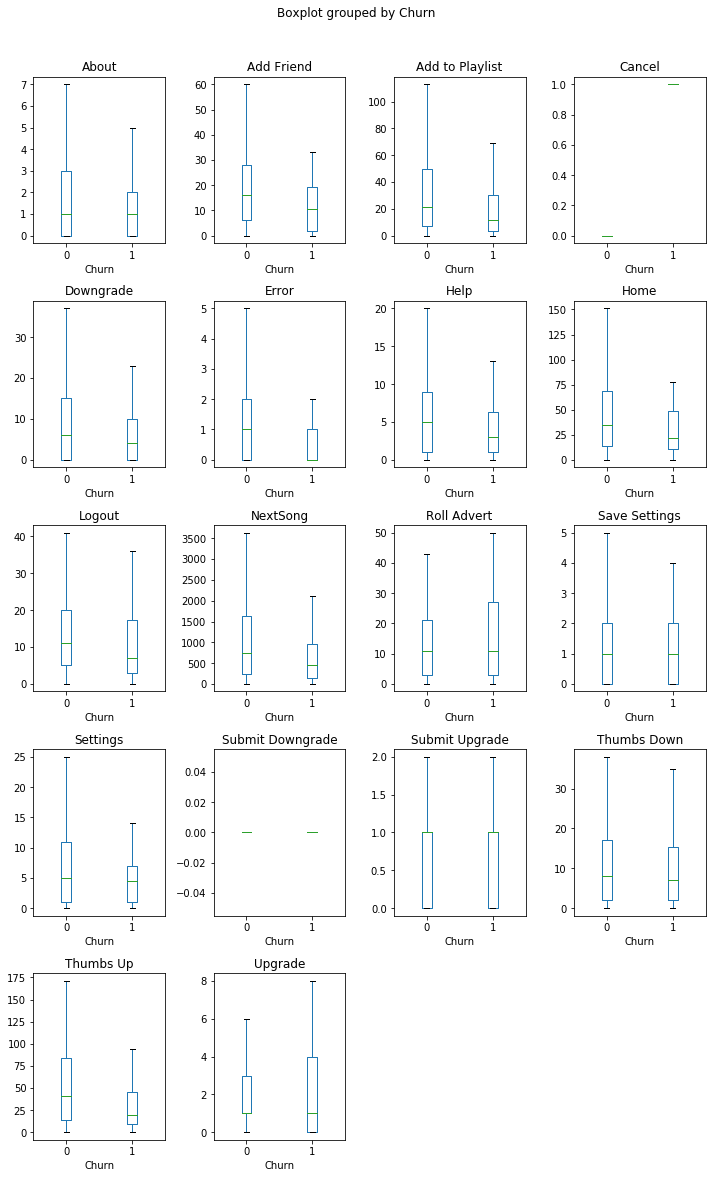

In [31]:
plot_columns = churn_page.drop("Churn", axis=1).columns

fig = plt.figure(figsize=(10,20))

for i in np.arange(1, len(plot_columns)):
    ax = fig.add_subplot(6, 4, i)
    churn_page.boxplot(plot_columns[i], ax=ax, grid=False, by="Churn", showfliers=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95]);

According to the boxplot printed above, the following variables could be used to determine whether a customer will cancel his service or not :  
- Add Friend  
- Add to Playlist  
- Help  
- Home  
- Logout  
- NextSong  
- Thumbs Up  

Basicaly theses features corresponds to interactions with the service which means the user uses it and is unlikely to cancel it.

###### 6. time variable

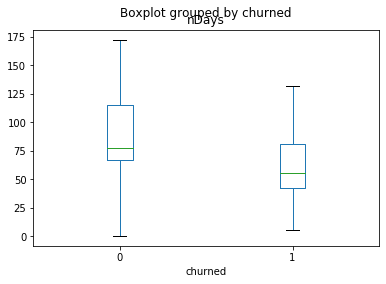

In [32]:
#number of days since registration
df_clean.toPandas().boxplot("nDays", by="churned", grid=False, showfliers=False);

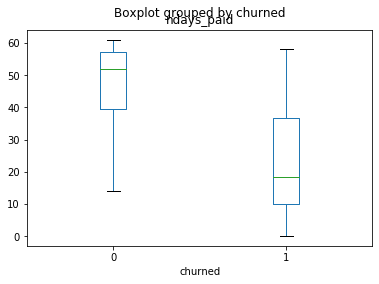

In [33]:
#number of days as paid user
df_clean.toPandas().boxplot("ndays_paid", by="churned", grid=False, showfliers=False);

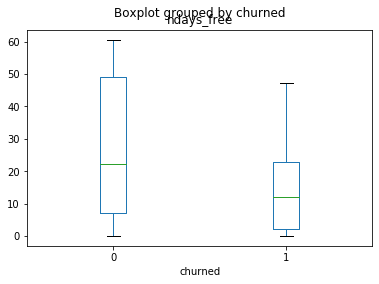

In [34]:
#number of days as free user
df_clean.toPandas().boxplot("ndays_free", by="churned", grid=False, showfliers=False);

As we can see above, the 3 variable created have clearly different values for the churned users than for the non churned users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Finaly, after the exploratory analysis, I chose to keep the following variables for the modeling :  
- gender  
- level  
- averag length of songs  
- nDays : number of days since registration  
- ndays_paid : number of days as paid user  
- ndays_free : number of days as free user  
- page : with a one-hot-encoding and keeping the following values : Add Friend, Add to Playlist, Help, Home, Logout, NextSong, Thumbs Up

###### 0. initialize the dataset for the model

In [35]:
df_clean.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- top_churn: integer (nullable = true)
 |-- churned: integer (nullable = false)
 |-- nDays: double (nullable = true)
 |-- ndays_paid: double (nullable = true)
 |-- ndays_free: double (nullable = true)



In [36]:
df_model = df_clean.drop("artist", "auth", "firstName", "itemInSession", "lastName", "location", "method",
                        "registration", "song", "userAgent", "top_churn")

###### 1. pivot the page column and keep the selected features

In [37]:
df_model = df_model.groupBy("userId").pivot("page").count().fillna(0)
df_model = df_model.drop("About", "Cancel", "Login", "Submit Registration", "Register", "Save Settings", 
                         "Downgrade", "Roll Advert", "Settings", "Upgrade", "Thumbs Down",
                        "Submit Downgrade", "Submit Upgrade", "Error")

###### 2. add length per user

In [38]:
length_per_user = df_clean.filter(df_clean.page=="NextSong")\
    .groupBy(df_clean.userId)\
    .sum("length")

df_model = df_model.join(length_per_user, "userId", "left")\
    .withColumnRenamed("sum(length)", "length")

###### 3. rename Cancellation Confirmation

In [39]:
df_model = df_model.withColumnRenamed("Cancellation Confirmation", "label")

###### 4. gender

In [40]:
#gender : 1=F, 0=M
user_gender = df_clean.select("userId", "gender") \
    .dropDuplicates() \
    .sort("userId") \
    .replace(["F", "M"], ["0", "1"], "gender")

user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

df_model = df_model.join(user_gender, on="userId", how="left")

###### 5. level

In [41]:
#level : 0=free, 1=paid
#because of users who change level, we select the last observation of each user for the level variable
#it might be interesting to know whether changing of level can explain the cancellation but it is not this project's goal
user_level = df_clean.groupby("userId", "level") \
    .agg({"ts": "max"}) \
    .sort("userId", "level") \
    .withColumnRenamed("max(ts)", "levelTime")

user_last_obs_time = user_level.groupby("userId") \
    .agg({"levelTime": "max"}) \
    .sort("userId") \
    .withColumnRenamed("max(levelTime)", "LastTime")

user_last_obs = user_last_obs_time.join(user_level, ["userId"]) 

user_last_obs = user_last_obs.filter(user_last_obs.LastTime==user_last_obs.levelTime) \
    .select("userId", "level") \
    .sort("userId") \
    .replace(["free", "paid"], ["0", "1"], "level")

user_last_obs = user_last_obs.select("userId", user_last_obs.level.cast("int"))

df_model = df_model.join(user_last_obs, on="userId", how="left")

###### 6. date variables : nDays, ndays_paid, ndays_free

In [42]:
date_variables = df_clean.select("userId", "nDays", "ndays_paid", "ndays_free").dropDuplicates()

df_model = df_model.join(date_variables, on="userId", how="left")

###### 7. fill empty values with 0

In [43]:
df_model = df_model.fillna(0)

In [44]:
df_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Add Friend: long (nullable = true)
 |-- Add to Playlist: long (nullable = true)
 |-- label: long (nullable = true)
 |-- Help: long (nullable = true)
 |-- Home: long (nullable = true)
 |-- Logout: long (nullable = true)
 |-- NextSong: long (nullable = true)
 |-- Thumbs Up: long (nullable = true)
 |-- length: double (nullable = false)
 |-- gender: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- nDays: double (nullable = false)
 |-- ndays_paid: double (nullable = false)
 |-- ndays_free: double (nullable = false)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [47]:
#define the features and the target of the models
feature_columns = df_model.drop("userId", "label").columns

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

#scale the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True)

#model to be trained : logistic regression and random forest classifier
lr = LogisticRegression(featuresCol="scaledFeatures", maxIter=10, regParam=0.0, elasticNetParam=0)

rf = RandomForestClassifier(featuresCol="scaledFeatures")

gbt = GBTClassifier(featuresCol="scaledFeatures")

In [48]:
#build the 2 pipelines
lr_pipeline = Pipeline(stages=[assembler, scaler, lr])

rf_pipeline = Pipeline(stages=[assembler, scaler, rf])

gbt_pipeline = Pipeline(stages=[assembler, scaler, gbt])

In [49]:
#split into train and validation sets
train_set, valid_set = df_model.randomSplit([0.8, 0.2], seed=42)

In [50]:
#how to evaluate the performance of a model : F1-score and confusion matrix
def modelEvaluation(model, valid_data):
    """
    Evaluate the f1-score of a model
    
    INPUT
    model : pipeline object
    valid_data : the validation dataset
    
    OUTPUT
    f1-score
    accuracy score
    confusion matrix
    """
    #predictions on the validation dataset
    preds = model.transform(valid_data)
    
    #f1-score and accuracy
    f1_score = MulticlassClassificationEvaluator(metricName="f1")
    
    #confusion matrix
    confusion_matrix = preds.groupby("label").pivot("prediction").count().toPandas()
    
    return f1_score.evaluate(preds), confusion_matrix

I wanted to try 3 models - logistic regression, random forest and gradient boosting - because they are pretty simple to do. Furthermore the logistic regression is currently used in situations like this where we want to separate our users into 2 classes - whether or not they cancel their service.  

For both models, I used a parameter grid in order to determine the best value of the parameters.  
For the logistic regression the parameter to optimize was the regParam parameter. I tried only 2 values because I wanted first to know whether it was a good idea or not.  
For the random forest classifier I tested several values for the maximal depth of the tree.

##### 1st model logistic regression
with a cross-validation with the following parameter : regParam = [0.0, 0.1, ]

In [51]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.1, ]) \
    .build()

crossval = CrossValidator(estimator=lr_pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(),
                         numFolds=3)

In [52]:
lr_model = crossval.fit(train_set)

In [53]:
lr_f1_score, lr_confusion_matrix = modelEvaluation(lr_model, valid_set)

In [54]:
print("f1-score for the logistic regression : {}".format(lr_f1_score))

f1-score for the logistic regression : 0.7262656475019387


In [55]:
print("confusion matrix for the logistic regression :")
lr_confusion_matrix

confusion matrix for the logistic regression :


,label,0.0,1.0
0,0,26,NaN
1,1,7,1.0


###### 2nd model : random forest classifier

In [56]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.impurity, ["entropy", "gini"]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

crossval = CrossValidator(estimator=rf_pipeline,
                         estimatorParamMaps=paramGrid,
                         evaluator=MulticlassClassificationEvaluator(),
                         numFolds=3)

In [57]:
rf_model = crossval.fit(train_set)

In [58]:
rf_f1_score, rf_confusion_matrix = modelEvaluation(rf_model, valid_set)

In [59]:
print("f1-score for the random forest classifier : {}".format(rf_f1_score))

f1-score for the random forest classifier : 0.7797160243407708


In [60]:
print("confusion matrix for the random forest classifier :")
rf_confusion_matrix

confusion matrix for the random forest classifier :


,label,0.0,1.0
0,0,26,NaN
1,1,6,2.0


###### 3rd model : gradient boosting classifier

In [62]:
gbt_model = gbt_pipeline.fit(train_set)

In [63]:
gbt_f1_score, gbt_confusion_matrix = modelEvaluation(gbt_model, valid_set)

In [64]:
print("f1-score for the gradient boosting classifier : {}".format(gbt_f1_score))

f1-score for the gradient boosting classifier : 0.7163398692810458


In [65]:
print("confusion matrix for the gradient boosting classifier :")
gbt_confusion_matrix

confusion matrix for the gradient boosting classifier :


,label,0.0,1.0
0,0,20,6
1,1,4,4


###### Conclusion

The random forest classifier has the best f1-score : that is the model we will deploy later.

###### the selected model parameters

In [74]:
rf_model.bestModel.stages[-1]._java_obj.getMaxDepth(), rf_model.bestModel.stages[-1]._java_obj.getImpurity()

(5, 'gini')

###### feature importance

In [66]:
feature_importance = pd.DataFrame.from_dict({"feature": valid_set.drop("userId", "label").columns,
                      "importance": rf_model.bestModel.stages[2].featureImportances})

feature_importance = feature_importance.sort_values(by="importance", ascending=False)

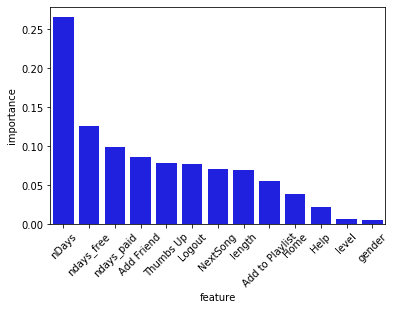

In [67]:
sb.barplot(x="feature", y="importance", color="blue", data=feature_importance)
plt.xticks(rotation=45);

###### save the best model in order to import it

In [68]:
rf_model.bestModel.save("rf_model.model")

###### Improvement
The first room of improvement would be to train the models on a bigger dataset. We could also potentialy user other features. Finaly we could also take look into the users who downgrade their service.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

The next step will be to run the model on AWS in order to use the full database.